In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torch.optim as optim
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np

# Xarxes convolucionals

L'objectiu d'avui és la creació d'una xarxa convolucional que obtengui **com a mínim igual resultat que la xarxa completament connectada implementada la setmana anterior però amb menys paràmetres**. Per poder realitzar comparacions directes emprarem el mateix conjunt de dades.

Com objectius secundaris tenim:

1. Aprenentatge de noves estratègies per evitar `overfitting`.
2. Us d'un nou optimitzador.
3. Visualització dels resultats dels filtres convolucionals.

Primer de tot, com sempre, les dades:


In [2]:
# Recordau: El label del dataset és l'índex de la llista labels. Cada posició de la llista és un codi ASCII. Podeu emprar la funció chr per fer la transformació

# Definim una seqüència (composició) de transformacions
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),  # mitjana, desviacio tipica (precalculats)
    ]
)

# Descarregam un dataset ja integrat en la llibreria Pytorch:
train = datasets.EMNIST(
    "data", split="digits", train=True, download=True, transform=transform
)  ## Si acabau podeu fer proves amb el split "balanced"
test = datasets.EMNIST("data", split="digits", train=False, transform=transform)

100%|██████████| 561753746/561753746 [00:23<00:00, 24066286.30it/s]


Extracting data\EMNIST\raw\gzip.zip to data\EMNIST\raw


In [3]:
train_batch_size = 64
test_batch_size = 100

# Transformam les dades en l'estructura necessaria per entrenar una xarxa
train_loader = torch.utils.data.DataLoader(train, train_batch_size)
test_loader = torch.utils.data.DataLoader(test, test_batch_size)

## Definició de la xarxa

### Feina a fer

1. Definir la primera xarxa convolucional. A continuació teniu una llista de les capes que podeu emprar:

-   `Conv2d`: Capa convolucional en 2 dimensions ([enllaç](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)). Com a paràmetres principals trobarem:

    -   in_channels: canals d'entrada.
    -   out_channels : canals de sortida.
    -   kernel_size: mida del filtre.
    -   stride: desplaçament del filtre. Típicament pren per valor 1.
    -   padding: ampliació de la imatge per evitar pèrdua de dimensionalitat.

-   `MaxPool2d`: Capa de max pooling ([enllaç](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html#torch.nn.MaxPool2d)). Aquesta capa no té paràmetres entrenables. Però si:

    -   kernel_size: Mida del filtre del qual es seleccionarà el màxim.
    -   stride: desplaçament del filtre.

-   `Dropout`: Dropout és un mètode de regularització (evitar `overfitting`) que aproxima l'entrenament d'un gran nombre de xarxes neuronals amb diferents arquitectures en paral·lel. Durant l'entrenament, una part de les sortides de la capa s'ignoren aleatòriament o s'abandonen. Això té l'efecte de fer que la capa sembli i es tracti com una capa amb un nombre diferent de nodes i connectivitat a la capa anterior. En efecte, cada actualització d'una capa durant l'entrenament es realitza amb una vista diferent de la capa configurada. Hem d'especificar quines capes tenen `dropout` de manera individual. Té un únic paràmetre amb valor per defecte $p=0.5$ Els valors típics d'aquest paràmetre varien entre $0.5$ i $0.8$.

-   `Linear`

-   `ReLU`

2. Per posibilitar la visualització de les imatges passades per les capes convolucionals farem que funció `forward` tengui diverses sortides (diferents valors de `return`) un per cada capa convolucional de la xarxa.


In [4]:
in_channels = 3  # Número de canales de entrada (RGB en este caso)
out_channels = 96  # Número de filtros
kernel_size = 11  # Tamaño del filtro (ancho y alto)
stride = 4  # Stride
padding = 0  # Padding

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=3, stride=1, padding=1)  # 28x28x1 -> 28x28x10
        self.mp1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  # 28x28x10 -> 14x14x10
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=3, stride=1, padding=1)  # 14x14x10 -> 14x14x20
        self.mp2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  # 14x14x20 -> 7x7x20
        self.fc1 = nn.Linear(7 * 7 * 20, 100)  # 7x7x20 -> 100
        self.fc2 = nn.Linear(100, 10)  # 100 -> 10

    def forward(self, x):
        out_conv1 = self.conv1(x)
        x = F.relu(out_conv1)
        x = self.mp1(x)
        out_conv2 = self.conv2(x)
        x = F.relu(out_conv2)
        x = self.mp2(x)
        x = x.view(-1, 7 * 7 * 20)  # flatten
        # x = x.flatten()
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output, out_conv1, out_conv2

## Entrenament

Aquesta part, per sort, no varia massa de la setmana anterior:

### Feina a fer

1. Modificar la sortida de la xarxa, ara retorna diversos valors, encara que aquí només us interessa un.


In [8]:
def train(model, device, train_loader, optimizer, epoch, log_interval=100, verbose=True):
    model.train()

    loss_v = 0

    for batch_idx, (data, target) in (t := tqdm(enumerate(train_loader), total=len(train_loader))):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output, _, _ = model(data)
        loss = F.cross_entropy(output, target, reduction="sum")
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0 and verbose:
            t.set_description(
                "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Average: {:.6f}".format(
                    epoch,
                    batch_idx * len(data),
                    len(train_loader.dataset),
                    100.0 * batch_idx / len(train_loader),
                    loss.item(),
                    loss.item() / len(data),
                )
            )

        loss_v += loss.item()

    loss_v /= len(train_loader.dataset)
    print("\nTrain set: Average loss: {:.4f}\n".format(loss_v))

    return loss_v


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in tqdm(test_loader, total=len(test_loader)):
            data, target = data.to(device), target.to(device)
            output, _, _ = model(data)
            test_loss += F.cross_entropy(output, target, reduction="sum")
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print(
        "\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
            test_loss, correct, len(test_loader.dataset), 100.0 * correct / len(test_loader.dataset)
        )
    )

    return test_loss

A continuació definim els paràmetres d'entrenament i el bucle principal:

### Adam

Aquesta setmana introduirem un nou algorisme d'optimització anomenat `Adam`. Fins ara hem emprat el descens del gradient (`SGD`).

`Adam` és un algorisme d'optimització amplament emprat, tal com el descens del gradient, és iteratiu. A la literatura trobam arguments que indiquen que, tot i que Adam convergeix més ràpidament, SGD generalitza millor que Adam i, per tant, pot resultar en un rendiment final millor.

[Més info](https://medium.com/geekculture/a-2021-guide-to-improving-cnns-optimizers-adam-vs-sgd-495848ac6008)

### Feina a fer:

1. Mostrar el nombre de paràmetres de la xarxa i compara-ho amb el nombre de paràmetres amb la xarxa de la setmana passada). Fes la teva xarxa més petita fins que el resultat decaigui.

```
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
```

2. Dibuixar els gràfics de la funció de pèrdua amb les dues funcions d'optimització que coneixem: comparar `SGD` amb `ADAM`.


In [10]:
torch.manual_seed(33)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

epochs = 10
lr = 0.00001

model = Net().to(device)
print(model)

optimizer = optim.Adam(model.parameters(), lr=lr)

# Guardam el valor de peèrdua mig de cada iteració (època)
train_l = np.zeros((epochs))
test_l = np.zeros((epochs))

# Bucle d'entrenament
for epoch in range(0, epochs):
    train_l[epoch] = train(model, device, train_loader, optimizer, epoch)
    test_l[epoch] = test(model, device, test_loader)

Device: cuda
Net(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (mp1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (mp2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=980, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
)


  0%|          | 0/3750 [00:00<?, ?it/s]

Train Epoch: 0 [236800/240000 (99%)]	Loss: 17.733034, Average: 0.277079: 100%|██████████| 3750/3750 [01:07<00:00, 55.67it/s]



Train set: Average loss: 0.9170



100%|██████████| 400/400 [00:07<00:00, 50.24it/s]



Test set: Average loss: 0.3162, Accuracy: 36429/40000 (91%)



Train Epoch: 1 [236800/240000 (99%)]	Loss: 8.733717, Average: 0.136464: 100%|██████████| 3750/3750 [00:59<00:00, 62.91it/s] 



Train set: Average loss: 0.2466



100%|██████████| 400/400 [00:07<00:00, 53.87it/s]



Test set: Average loss: 0.2068, Accuracy: 37538/40000 (94%)



Train Epoch: 2 [236800/240000 (99%)]	Loss: 5.454785, Average: 0.085231: 100%|██████████| 3750/3750 [00:59<00:00, 62.66it/s] 



Train set: Average loss: 0.1851



100%|██████████| 400/400 [00:07<00:00, 52.02it/s]



Test set: Average loss: 0.1673, Accuracy: 38044/40000 (95%)



Train Epoch: 3 [236800/240000 (99%)]	Loss: 3.440967, Average: 0.053765: 100%|██████████| 3750/3750 [01:00<00:00, 62.49it/s] 



Train set: Average loss: 0.1543



100%|██████████| 400/400 [00:07<00:00, 53.88it/s]



Test set: Average loss: 0.1418, Accuracy: 38350/40000 (96%)



Train Epoch: 4 [236800/240000 (99%)]	Loss: 2.256839, Average: 0.035263: 100%|██████████| 3750/3750 [00:59<00:00, 62.99it/s] 



Train set: Average loss: 0.1324



100%|██████████| 400/400 [00:07<00:00, 54.54it/s]



Test set: Average loss: 0.1226, Accuracy: 38562/40000 (96%)



Train Epoch: 5 [236800/240000 (99%)]	Loss: 1.575140, Average: 0.024612: 100%|██████████| 3750/3750 [01:00<00:00, 62.41it/s] 



Train set: Average loss: 0.1155



100%|██████████| 400/400 [00:06<00:00, 58.24it/s]



Test set: Average loss: 0.1076, Accuracy: 38725/40000 (97%)



Train Epoch: 6 [236800/240000 (99%)]	Loss: 1.191340, Average: 0.018615: 100%|██████████| 3750/3750 [01:02<00:00, 60.23it/s] 



Train set: Average loss: 0.1022



100%|██████████| 400/400 [00:07<00:00, 55.64it/s]



Test set: Average loss: 0.0956, Accuracy: 38873/40000 (97%)



Train Epoch: 7 [236800/240000 (99%)]	Loss: 0.914585, Average: 0.014290: 100%|██████████| 3750/3750 [01:02<00:00, 60.35it/s] 



Train set: Average loss: 0.0916



100%|██████████| 400/400 [00:07<00:00, 52.25it/s]



Test set: Average loss: 0.0860, Accuracy: 38984/40000 (97%)



Train Epoch: 8 [236800/240000 (99%)]	Loss: 0.711199, Average: 0.011112: 100%|██████████| 3750/3750 [01:00<00:00, 61.76it/s] 



Train set: Average loss: 0.0830



100%|██████████| 400/400 [00:07<00:00, 52.90it/s]



Test set: Average loss: 0.0783, Accuracy: 39066/40000 (98%)



Train Epoch: 9 [236800/240000 (99%)]	Loss: 0.567035, Average: 0.008860: 100%|██████████| 3750/3750 [00:59<00:00, 62.69it/s] 



Train set: Average loss: 0.0761



100%|██████████| 400/400 [00:07<00:00, 51.69it/s]


Test set: Average loss: 0.0719, Accuracy: 39132/40000 (98%)



## Resultats

Aquí visualitzarem els resultats d'aprenentatge de la xarxa.

### Feina a fer:

1. Fer una predicció del primer _batch_ del conjunt de _test_.
2. Visualitzar una imatge del _batch_ i posar la predicció i el groun truth com a títol de la imatge.
3. Visualitzar el resultat de la mateixa imatge passada per tots els filtres de la primera convolució de la vostra xarxa.
4. **Extra**: Fer la matriu de confusió de les 10 classes per poder entendre el que no estau fent bé (la xarxa no està fent bé).

A tenir en compte:

#### Subplots

Per fer graelles d'imatges podeu empar la funció `subplots`. Més [informació](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html)

#### Device

Si heu emprat _GPU_ per accelerar el procés d'entrenament, els resultats que obtenim de la xarxa també seràn a la _GPU_. **Pytorch** proporciona la funció `cpu()` que retorna una còpia d'aquest objecte a la memòria de la CPU.

#### Detach

Per poder operar amb els resultats de la predicció emprarem la funció `detach` que retorna un nou Tensor "separat" del graf (xarxa) en curs.

Per tant per transformar el tensor que retorna la xarxa en un array de la lliberia _Numpy_ caldria fer el següent:

```
resultat_np = resultat.detach().numpy()
```

Si a més hem executat l'entrenament en _GPU_:

```
resultat_np = resultat.cpu().detach().numpy()
```


In [11]:
def generador(loader):
    for data, target in loader:
        yield data, target

In [50]:
# 1. Fer una predicció del primer _batch_ del conjunt de _test_.
X_test, y_test = next(generador(test_loader))
X_test, y_test = X_test.to(device), y_test.to(device)
output, out_conv1, out_conv2 = model(X_test)

In [51]:
# 2. Visualitzar una imatge del _batch_ i posar la predicció i el groun truth com a títol de la imatge.
if device != "cpu":
    X_test = X_test.cpu()
    y_test = y_test.cpu()

X_test = X_test.detach().numpy()
y_test = y_test.detach().numpy()

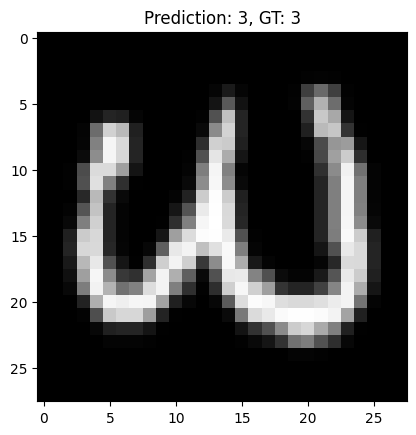

In [60]:
import random

idx = random.randint(0, len(X_test) - 1)
plt.imshow(X_test[idx][0], cmap="gray")
plt.title(f"Prediction: {output.argmax(dim=1)[idx]}, GT: {y_test[idx]}")
plt.show()

In [53]:
# 3. Visualitzar el resultat de la mateixa imatge passada per tots els filtres de la primera convolució de la vostra xarxa.
if device != "cpu":
    out_conv1 = out_conv1.cpu()
    out_conv2 = out_conv2.cpu()

out_conv1 = out_conv1.detach().numpy()
out_conv2 = out_conv2.detach().numpy()

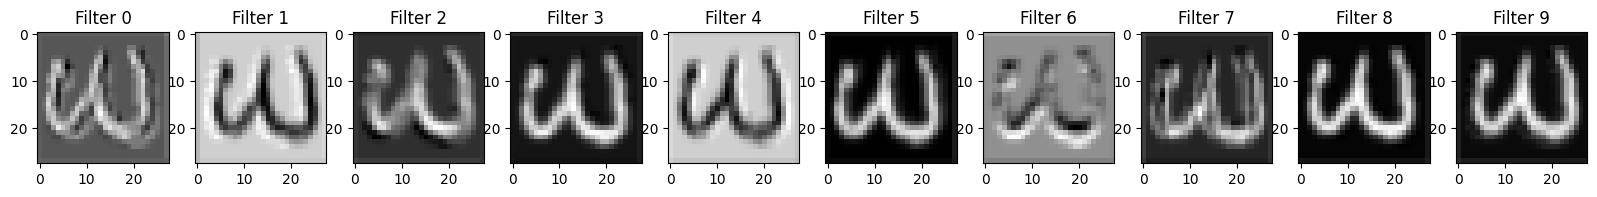

In [61]:
plt.figure(figsize=(20, 20))
rang = len(out_conv1[idx])
for i in range(rang):
    plt.subplot(1, rang, i + 1)
    plt.imshow(out_conv1[idx][i], cmap="gray")
    plt.title(f"Filter {i}")

plt.show()

20


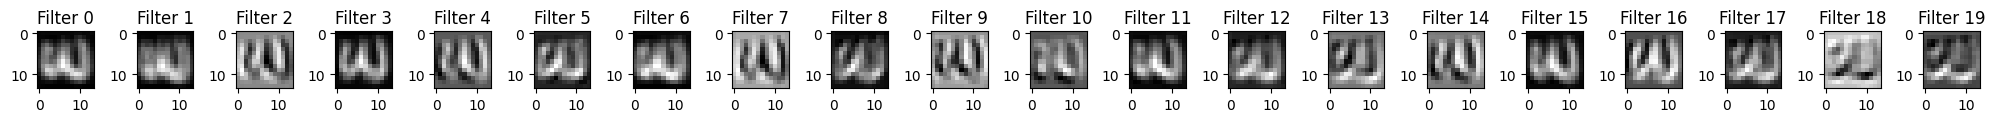

In [62]:
plt.figure(figsize=(20, 20))
rang = len(out_conv2[idx])
print(rang)
for i in range(rang):
    plt.subplot(1, rang, i + 1)
    plt.imshow(out_conv2[idx][i], cmap="gray")
    plt.title(f"Filter {i}") 

plt.tight_layout()
plt.show()

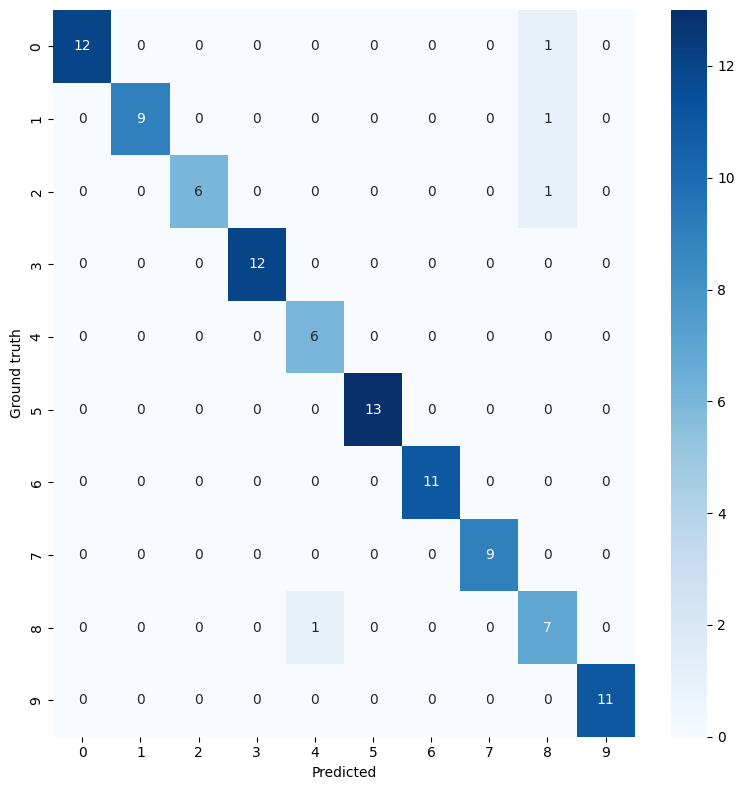

In [63]:
# 4. **Extra**: Fer la matriu de confusió de les 10 classes per poder entendre el que no estau fent bé (la xarxa no està fent bé).
from sklearn.metrics import confusion_matrix
import seaborn as sns

if device != "cpu":
    output = output.cpu()

y_pred = output.argmax(dim=1).detach().numpy()
y_test = y_test.astype(np.int64)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Ground truth")
plt.tight_layout()
plt.show()